# Load in modules

In [1]:
import os
import datetime
import pandas as pd
import datetime, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import string

In [2]:
os.getcwd()

'G:\\My Drive\\compsci\\DataScience\\portfolio\\merge_intervals'

# Read in data

In [3]:
file = r'dummy_data.csv'

In [4]:
df = pd.read_csv(file)
df

,org,valid_from,valid_to
0,x,01.01.2016,01.07.2017
1,x,01.12.2016,01.07.2017
2,x,01.03.2016,01.04.2016
3,x,01.01.2019,01.01.2020
4,x,01.03.2020,01.01.4891
5,y,01.01.2017,01.02.2017
6,y,02.02.2017,01.01.2018
7,y,01.03.2020,01.01.4891
8,y,01.01.2016,01.02.2017


# Create synthetic example: convert dates to ints

In [5]:
# extract unique dates from imported data
unique_dates_strings = pd.unique(df[['valid_from', 'valid_to']].values.ravel('K'))

# sort unique dates 
unique_dates_strings = sorted(unique_dates_strings, key=lambda date: datetime.datetime.strptime(date, "%d.%m.%Y"))

# create a unique key:value dictionary based on sorted dates & increasing ints
dct = {}
i = 1
for date in unique_dates_strings: 
    dct[date] = i
    i += 1

# convert dates to integers in table
df = df.assign(start=df.valid_from.map(dct), end=df.valid_to.map(dct))
df

,org,valid_from,valid_to,start,end
0,x,01.01.2016,01.07.2017,1,8
1,x,01.12.2016,01.07.2017,4,8
2,x,01.03.2016,01.04.2016,2,3
3,x,01.01.2019,01.01.2020,10,11
4,x,01.03.2020,01.01.4891,12,13
5,y,01.01.2017,01.02.2017,5,6
6,y,02.02.2017,01.01.2018,7,9
7,y,01.03.2020,01.01.4891,12,13
8,y,01.01.2016,01.02.2017,1,6


In [6]:
# Simplify table to only contain ints
df_synthetic = df[['org', 'start', 'end']].copy()
df_synthetic

,org,start,end
0,x,1,8
1,x,4,8
2,x,2,3
3,x,10,11
4,x,12,13
5,y,5,6
6,y,7,9
7,y,12,13
8,y,1,6


In [7]:
# sort by org & start int
df_synthetic.sort_values(by=['org', 'start'], inplace=True)
df_synthetic

,org,start,end
0,x,1,8
2,x,2,3
1,x,4,8
3,x,10,11
4,x,12,13
8,y,1,6
5,y,5,6
6,y,7,9
7,y,12,13


# Plot synthetic data per category

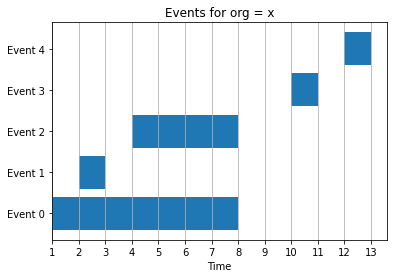

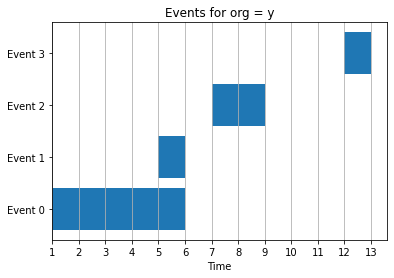

In [8]:
# Plot timelines per org category
for org in df_synthetic['org'].unique():
    begin = df_synthetic[df_synthetic['org'] == org]['start']
    end =   df_synthetic[df_synthetic['org'] == org]['end']
    event = ["Event {}".format(i) for i in range(len(begin))]

    plt.barh(range(len(begin)),  end-begin, left=begin)

    plt.title(f'Events for org = {org}')
    plt.yticks(range(len(begin)), event)
    plt.xticks(range(1, df[['start', 'end']].max().max() + 1))
    plt.xlabel('Time')
    plt.grid(axis = 'x')
    plt.show()

# Functions to reduce table by identifying & grouping overlapping intervals

In [9]:
def reduce_intervals(df, cat, start_str, end_str):
    # Based on: https://stackoverflow.com/questions/39143918/reducing-overlapping-intervals-in-pandas-dataframe-in-an-optimal-fashion
    
    # Identify overlapping intervals
    # Sort table   
    tmp = df.sort_values(by=[cat,start_str]).reset_index(drop=True)
    # Create a new column 'InPrev' thats true for all rows > 0, if start time at Event_(X) > end time at Event_(X-1)
    tmp.loc[0,'InPrev'] = bool(False)
    tmp.InPrev.to_numpy()[1:] = tmp.loc[1:,start_str].reset_index(drop=True) > tmp.loc[:(len(tmp)-2),end_str].reset_index(drop=True)
    tmp['InPrev'] = tmp['InPrev'].astype('bool')
    # Create a new column 'GrpCount' that creates a cumulative sum of all 'InPrev' column bools 
    # If 'GrpCount' does not change value between subsequent rows, these rows will be grouped into a single interval
    tmp['GrpCount'] = tmp.groupby([cat])['InPrev'].cumsum()
    
    # Group overlapping intervals
    # 1. Group table per 'org' & 'GrpCount'
    # 2. Aggregate data based on min/max within each group
    # 3. Reset index & keep only 'org','start','end' columns (i.e. get rid of 'InPrev' & 'GrpCount' columns)
    df_reduced = tmp.groupby([cat,'GrpCount'])\
    .agg({start_str:np.min,end_str:np.max})\
    .reset_index()[[cat,start_str,end_str]]
    
    return df_reduced

def reduction_loop(df_synthetic, n_iter, cat, start_str, end_str, DEBUG=1):
    
    # Identify & group overlapping intervals
    red_df = reduce_intervals(df_synthetic, cat, start_str, end_str)
    
    # DEBUG: keep track of how the data tables look like
    if DEBUG == 1:
        print('\n Prior df (iteration = 0)')
        print(df_synthetic)

        print('\n Posterior df (iteration = 1)')
        print(red_df)
        print('\n')
    
    
    if red_df is None:
        print('Output is empty. Critical Error!!!')
    
    # If red_df == df_synthetic, then stop
    if red_df.equals(df_synthetic):
        print('Max reduction')
        print(f'Iteration = 1\n')
    else:
        df_synthetic = red_df.copy()
        
        i = 1
        while i < n_iter:
            print(f'Finished iteration = {i}. Progress to next itreation... \n')
            # Identify & group overlapping intervals
            red_df = reduce_intervals(df_synthetic, cat, start_str, end_str)
            
            # DEBUG: keep track of how the data tables look like
            if DEBUG == 1:
                print(f'\n Prior df (iteration = {i})')
                print(df_synthetic)
                print(f'\n Posterior df (iteration = {i + 1})')
                print(red_df)
                print('\n')
            
            # If red_df == df_synthetic, then stop
            if red_df.equals(df_synthetic):
                print(f'Data reduction succesful! Stopped at iteration {i + 1}\n')
                break
            else:
                df_synthetic = red_df.copy()
                i += 1
                
        # if max possible number of iterations is reached, then stop
        if i == n_iter:
            print(f'Data reduction failed! Stopped at iteration {i}\n')

    return red_df
    

In [10]:
# Run grouping functions & measure time

current_time = time.time()

# n = number of iterations
n_iter = 5

df_reduced = reduction_loop(df_synthetic, n_iter, 'org', 'start', 'end', DEBUG=0)


elapsed_time = time.time() - current_time
print(f'\nElapsed time = {elapsed_time}')

Finished iteration = 1. Progress to next itreation... 

Finished iteration = 2. Progress to next itreation... 

Data reduction succesful! Stopped at iteration 3


Elapsed time = 0.0359044075012207


In [11]:
print(f'Original table length = {len(df_synthetic)} \nvs reduced length = {len(df_reduced)}') 

Original table length = 9 
vs reduced length = 6


# Plot original vs grouped/reduced data 

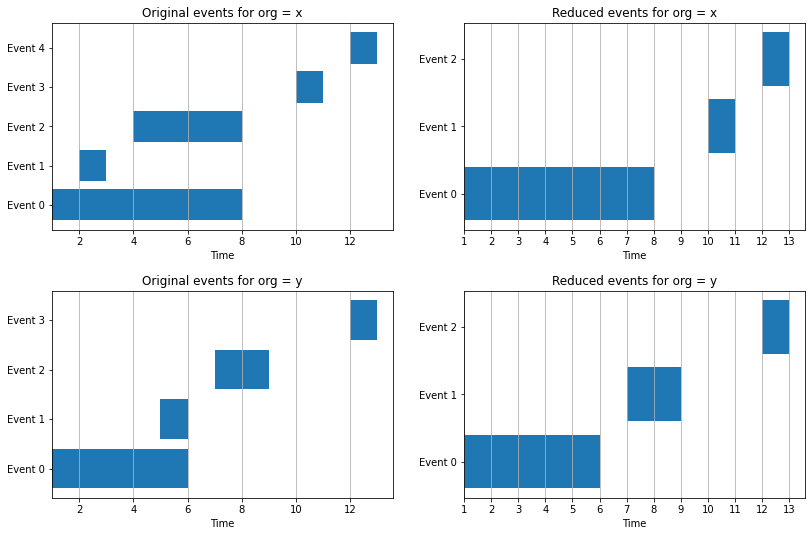

In [12]:
def plot_comparison_bar_graphs(df_original, df_reduced, org_str, start_str, end_str):
    fig, axs = plt.subplots(2, 2, figsize=(12,8))
    plt.tight_layout(pad=4)

    # Plot timelines per org
    i = 0
    for org in df_original[org_str].unique():
        begin = df_original[df_original[org_str] == org][start_str]
        end =   df_original[df_original[org_str] == org][end_str]
        event = ["Event {}".format(i) for i in range(len(begin))]
        
        if df_original[start_str].dtype == '<M8[ns]':
            edate, bdate = [mdates.date2num(item) for item in (end, begin)]
            ypos = range(len(end))
            axs[i, 0].barh(ypos,  edate-bdate, left=bdate)
            axs[i, 0].set_xlabel('Date')
            
            # Set x limits
            # MAX
            valid_from_max = df_original[start_str].max()
            valid_to_max = df_original[df_original[end_str] < df_original[end_str].max()][end_str].max()
            today = datetime.datetime.now()
            # MIN
            xmin = df_original[start_str].min()
            axs[i, 0].set_xlim(xmin, max(valid_from_max, valid_to_max, today))

            # We need to tell matplotlib that these are dates...
            axs[i, 0].xaxis_date()
            
        else:
            axs[i, 0].barh(range(len(begin)),  end-begin, left=begin)
            axs[i, 0].set_xlabel('Time')
        
        axs[i, 0].set_yticks(range(len(begin)), event)
        axs[i, 0].set_title(f'org = {org}, b4 resize')
        axs[i, 0].set_title(f'Original events for org = {org}')
        axs[i, 0].grid(axis = 'x')
        
        if df_original[start_str].dtype == '<M8[ns]':
            #axs[i, 1].set_xticks(range(df_original[[start_str, end_str]].min().min(), df_original[[start_str, end_str]].max().max() + datetime.timedelta(days=1)))
            print('Nada')
#             [i, 0].xaxis_date()
        else:
            axs[i, 1].set_xticks(range(1, df_original[[start_str, end_str]].max().max() + 1))
        


        begin = df_reduced[df_reduced[org_str] == org][start_str]
        end =   df_reduced[df_reduced[org_str] == org][end_str]
        event = ["Event {}".format(i) for i in range(len(begin))]
        
        if df_original[start_str].dtype == '<M8[ns]':
            edate, bdate = [mdates.date2num(item) for item in (end, begin)]
            ypos = range(len(end))
            axs[i, 1].barh(ypos,  edate-bdate, left=bdate)
            axs[i, 1].set_xlabel('Date')
            
            # Set x limits
            # MAX
            valid_from_max = df_reduced[start_str].max()
            valid_to_max = df_reduced[df_reduced[end_str] < df_reduced[end_str].max()][end_str].max()
            today = datetime.datetime.now()
            # MIN
            xmin = df_reduced[start_str].min()
            axs[i, 1].set_xlim(xmin, max(valid_from_max, valid_to_max, today))

            # We need to tell matplotlib that these are dates...
            axs[i, 1].xaxis_date()
        else:
            axs[i, 1].barh(range(len(begin)),  end-begin, left=begin)
            axs[i, 1].set_xlabel('Time')

        axs[i, 1].set_title(f'Reduced events for org = {org}')
        axs[i, 1].set_yticks(range(len(begin)), event)
        axs[i, 1].grid(axis = 'x')
        
        if df_original[start_str].dtype == '<M8[ns]':
            #axs[i, 1].set_xticks(range(df_original[[start_str, end_str]].min().min(), df_original[[start_str, end_str]].max().max() + datetime.timedelta(days=1)))
            print('Nada')
#             [i, 0].xaxis_date()
        else:
            axs[i, 1].set_xticks(range(1, df_original[[start_str, end_str]].max().max() + 1))
        

        i += 1
        
plot_comparison_bar_graphs(df_synthetic, df_reduced, 'org', 'start', 'end')

# Naive approach: for loop through all rows

In [13]:
def mergeIntervals_upd(arr, org, org_str, strt_str, end_str):
    # https://www.geeksforgeeks.org/merging-intervals/
    '''
    Space optimized approach: 
    The above solution requires O(n) extra space for the stack. 
    We can avoid the use of extra space by doing merge operations in place. 
    Below are detailed steps. 

    1. Sort all intervals in increasing order of start time.
    2. Traverse sorted intervals starting from the first interval, 
    3. Do the following for every interval.
        - If the current interval is not the first interval and it overlaps with the previous interval,
        then merge it with the previous interval. Keep doing it while the interval overlaps with the previous one.         
        - Otherwise, Add the current interval to the output list of intervals.

    Below is the implementation of the above approach:
    '''

    arr = sorted(arr, key=lambda x: x[0])
    
    # Stores index of last element
    # in output array (modified arr[])
    index = 0
 
    # Traverse all input Intervals starting from
    # second interval
    for i in range(1, len(arr)):
 
        # If this is not first Interval and overlaps
        # with the previous one, Merge previous and
        # current Intervals
#         arr_plusOne = arr[i][0] + datetime.timedelta(days=1)
        
        if arr[index][1] >= arr[i][0]:
            arr[index][1] = max(arr[index][1], arr[i][1])
        else:
            index = index + 1
            arr[index] = arr[i]
 
    df_reduced = pd.DataFrame(columns = [org_str, strt_str, end_str])
    for i in range(index+1):
        tmp = pd.DataFrame({org_str:org, strt_str:arr[i][0], end_str:arr[i][1]}, index=[i])
        df_reduced = pd.concat([df_reduced, tmp], ignore_index=True)
        
    return df_reduced

In [14]:
current_time = time.time()
df_synthetic_naive = df_synthetic.copy()

df_red = pd.DataFrame(columns = ['org', 'start', 'end'])

unique_orgs = df_synthetic['org'].unique()
for i in range(len(unique_orgs)):
    org = unique_orgs[i]

    df_org = df_synthetic_naive[df_synthetic_naive['org'] == org]
    df_arr = df_org[['start', 'end']].to_numpy()   
    df_reduced = mergeIntervals_upd(df_arr, org, 'org', 'start', 'end')
    
    df_red = pd.concat([df_red, df_reduced], ignore_index=True)
display(df_red)

elapsed_time = time.time() - current_time
print(f'\nElapsed time = {elapsed_time}')

,org,start,end
0,x,1,8
1,x,10,11
2,x,12,13
3,y,1,6
4,y,7,9
5,y,12,13



Elapsed time = 0.03334760665893555


# Create a massive data-set to measure time it takes to reduce data

In [15]:
row_num = 1000

letters_arr = np.random.choice(list(string.ascii_lowercase),  size=row_num)
start_arr = np.random.randint(30, size=row_num)
end_arr = start_arr + np.random.randint(30, size=row_num)

data = {'org' : letters_arr, 'start' : start_arr, 'end' : end_arr}
df_massive = pd.DataFrame(data)
df_massive


,org,start,end
0,s,0,8
1,e,5,5
2,u,16,25
3,s,18,43
4,u,16,20
...,...,...,...
995,g,4,12
996,c,2,27
997,e,25,47
998,x,17,32


In [16]:
# OPTIMIZED

# Run grouping functions & measure time
current_time = time.time()

# n = number of iterations
n_iter = 5
df_reduced = reduction_loop(df_massive, n_iter, 'org', 'start', 'end', DEBUG=0)


elapsed_time_opt = time.time() - current_time
print(f'\nElapsed time = {elapsed_time_opt}')

Finished iteration = 1. Progress to next itreation... 

Finished iteration = 2. Progress to next itreation... 

Data reduction succesful! Stopped at iteration 3


Elapsed time = 0.050865888595581055


In [17]:
df_reduced.info()
df_reduced

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   org     26 non-null     object
 1   start   26 non-null     int32 
 2   end     26 non-null     int32 
dtypes: int32(2), object(1)
memory usage: 544.0+ bytes


,org,start,end
0,a,0,51
1,b,0,57
2,c,1,49
3,d,0,56
4,e,0,53
5,f,0,52
6,g,0,46
7,h,1,50
8,i,2,50
9,j,0,52


In [18]:
# NAIVE

current_time = time.time()
df_synthetic_naive = df_massive.copy()

df_red = pd.DataFrame(columns = ['org', 'start', 'end'])

unique_orgs = df_massive['org'].unique()
for i in range(len(unique_orgs)):
    org = unique_orgs[i]

    df_org = df_synthetic_naive[df_synthetic_naive['org'] == org]
    df_arr = df_org[['start', 'end']].to_numpy()   
    df_reduced = mergeIntervals_upd(df_arr, org, 'org', 'start', 'end')
    
    df_red = pd.concat([df_red, df_reduced], ignore_index=True)

elapsed_time_naive = time.time() - current_time
print(f'\nElapsed time = {elapsed_time_naive}')


Elapsed time = 0.11269736289978027


In [19]:
df_red.info()
df_red

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   org     26 non-null     object
 1   start   26 non-null     object
 2   end     26 non-null     object
dtypes: object(3)
memory usage: 752.0+ bytes


,org,start,end
0,s,0,49
1,e,0,53
2,u,1,50
3,q,1,55
4,c,1,49
5,r,0,56
6,t,1,46
7,a,0,51
8,d,0,56
9,k,0,55


In [20]:
opt_vs_naive_diff = elapsed_time_opt - elapsed_time_naive
opt_vs_naive_gain = elapsed_time_naive / elapsed_time_opt
print(f'Optimized vs naive elaped time difference = {opt_vs_naive_diff} seconds')
print(f'Optimized vs naive x faster = {opt_vs_naive_gain} times')

Optimized vs naive elaped time difference = -0.06183147430419922 seconds
Optimized vs naive x faster = 2.215578377010223 times


# Datetime data

In [21]:
df.head()

,org,valid_from,valid_to,start,end
0,x,01.01.2016,01.07.2017,1,8
1,x,01.12.2016,01.07.2017,4,8
2,x,01.03.2016,01.04.2016,2,3
3,x,01.01.2019,01.01.2020,10,11
4,x,01.03.2020,01.01.4891,12,13


In [22]:
df.dtypes

org           object
valid_from    object
valid_to      object
start          int64
end            int64
dtype: object

In [23]:
print(pd.Timestamp.max)

2262-04-11 23:47:16.854775807


In [24]:
df['valid_from'] = pd.to_datetime(df['valid_from'], format='%d.%m.%Y')
df['valid_to'] = pd.to_datetime(df['valid_to'], format='%d.%m.%Y', errors = 'coerce')
df.fillna(pd.Timestamp.max - datetime.timedelta(days=1), inplace=True)
df.dtypes

org                   object
valid_from    datetime64[ns]
valid_to      datetime64[ns]
start                  int64
end                    int64
dtype: object

In [25]:
df

,org,valid_from,valid_to,start,end
0,x,2016-01-01,2017-07-01 00:00:00.000000000,1,8
1,x,2016-12-01,2017-07-01 00:00:00.000000000,4,8
2,x,2016-03-01,2016-04-01 00:00:00.000000000,2,3
3,x,2019-01-01,2020-01-01 00:00:00.000000000,10,11
4,x,2020-03-01,2262-04-10 23:47:16.854775807,12,13
5,y,2017-01-01,2017-02-01 00:00:00.000000000,5,6
6,y,2017-02-02,2018-01-01 00:00:00.000000000,7,9
7,y,2020-03-01,2262-04-10 23:47:16.854775807,12,13
8,y,2016-01-01,2017-02-01 00:00:00.000000000,1,6


In [26]:
# OPTIMIZED

# Run grouping functions & measure time
current_time = time.time()

# n = number of iterations
n_iter = 5
df_reduced = reduction_loop(df, n_iter, 'org', 'valid_from', 'valid_to', DEBUG=0)


elapsed_time = time.time() - current_time
print(f'\nElapsed time = {elapsed_time}')

Finished iteration = 1. Progress to next itreation... 

Finished iteration = 2. Progress to next itreation... 

Data reduction succesful! Stopped at iteration 3


Elapsed time = 0.049867868423461914


In [27]:
type(df_reduced['valid_to'][1])

pandas._libs.tslibs.timestamps.Timestamp

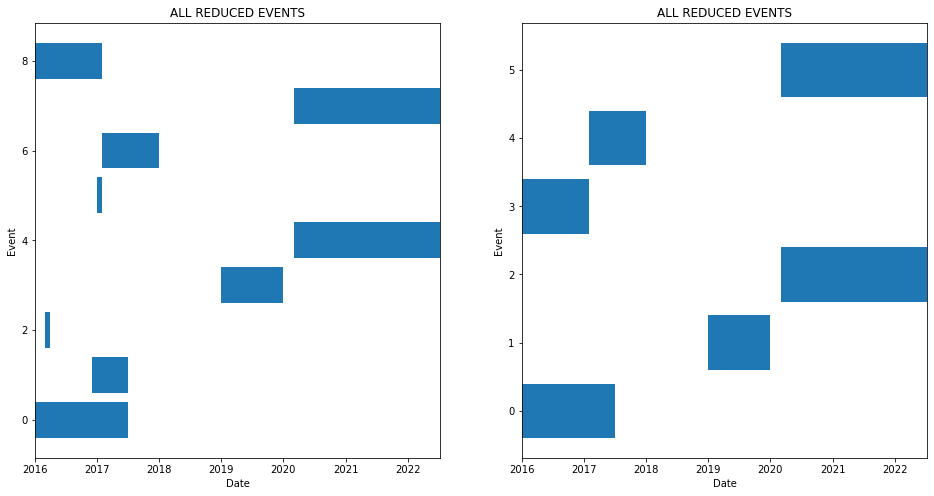

In [28]:
# https://stackoverflow.com/questions/11042290/how-can-i-use-xaxis-date-with-barh


fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot the ORIGINAL data
# Generate a series of dates for plotting...
bdate = df['valid_from']
edate = df['valid_to']

# Now convert them to matplotlib's internal format...
edate, bdate = [mdates.date2num(item) for item in (edate, bdate)]
ypos = range(len(edate))

ax[0].barh(ypos, edate - bdate, left=bdate, height=0.8, align='center')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Event')
ax[0].set_title('ALL REDUCED EVENTS')

ax[0].axis('tight')

# Set x limits
# MAX
valid_from_max = df['valid_from'].max()
valid_to_max = df[df['valid_to'] < df['valid_to'].max()]['valid_to'].max()
today = datetime.datetime.now()
# MIN
xmin = df['valid_from'].min()
ax[0].set_xlim(xmin, max(valid_from_max, valid_to_max, today))

# We need to tell matplotlib that these are dates...
ax[0].xaxis_date()

# Plot the REDUCED data
# Generate a series of dates for plotting...
bdate = df_reduced['valid_from']
edate = df_reduced['valid_to']

# Now convert them to matplotlib's internal format...
edate, bdate = [mdates.date2num(item) for item in (edate, bdate)]
ypos = range(len(edate))

ax[1].barh(ypos, edate - bdate, left=bdate, height=0.8, align='center')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Event')
ax[1].set_title('ALL REDUCED EVENTS')

ax[1].axis('tight')

# Set x limits
# MAX
valid_from_max = df_reduced['valid_from'].max()
valid_to_max = df_reduced[df_reduced['valid_to'] < df_reduced['valid_to'].max()]['valid_to'].max()
today = datetime.datetime.now()
# MIN
xmin = df_reduced['valid_from'].min()
ax[1].set_xlim(xmin, max(valid_from_max, valid_to_max, today))

# We need to tell matplotlib that these are dates...
ax[1].xaxis_date()

Nada
Nada
Nada
Nada


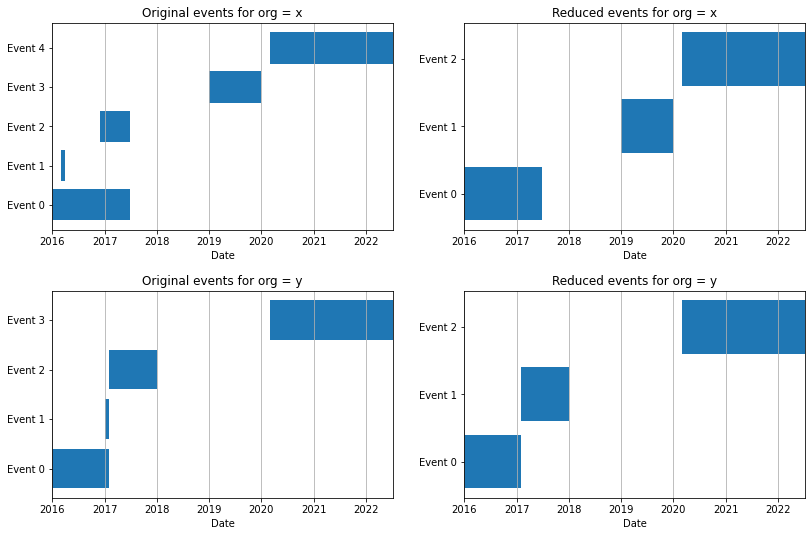

In [29]:
df.sort_values(by=['org', 'valid_from'], inplace=True)
df_reduced.sort_values(by=['org', 'valid_from'], inplace=True)
plot_comparison_bar_graphs(df, df_reduced, 'org', 'valid_from', 'valid_to')

# IMAGES

# Copied static images

# Dates
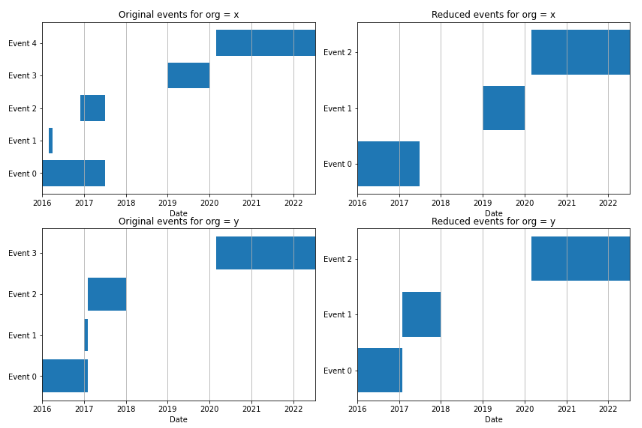

# Integers
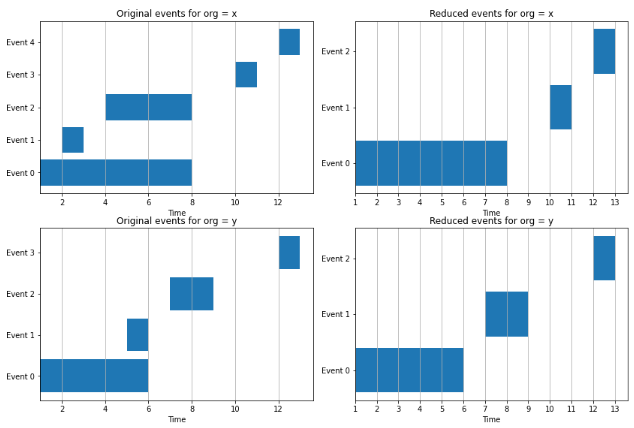